In [1]:
!pip install dask
!pip install numpy
!pip install pandas
!pip install pyarrow
!pip install plotly
!pip install nbformat
!pip show nbformat
!pip install seaborn
!pip install folium

Name: nbformat
Version: 5.10.4
Summary: The Jupyter Notebook format
Home-page: https://jupyter.org
Author: 
Author-email: Jupyter Development Team <jupyter@googlegroups.com>
License: BSD 3-Clause License

- Copyright (c) 2001-2015, IPython Development Team
- Copyright (c) 2015-, Jupyter Development Team

All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior writte

In [42]:
!pip install scikit-learn


   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------- ----------- 7.9/11.1 MB 44.2 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 36.5 MB/s eta 0:00:00


In [55]:
!pip install ace_tools

In [1]:
import sys
print(sys.executable)

c:\Users\atul1\Work\tools\Python3_12\python.exe


In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import scipy.stats as stats



#https://simplemaps.com/data/us-cities

In [9]:
fl_data_file = r"..\data\state_wise_data\FL_org.csv"
chunk_size = 100000  # Adjust based on available memory

In [4]:
# Creating a DataFrame from the given data
# https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-detail.html?utm_source=chatgpt.com
USA_2023_POPULATION_DATA = {
    "State": [
        "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "DC", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY",
        "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH",
        "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
    ],
    "Population": [
        3977628, 557899, 5848310, 2362124, 30519524, 4662926, 2894190, 819952, 552380, 18229883,
        8490546, 1141525, 1497384, 9844167, 5274945, 2476882, 2246209, 3509259, 3506600, 1146670,
        4818337, 5659598, 7925350, 4436981, 2259864, 4821686, 897161, 1497381, 2508220, 1150004,
        7280551, 1663024, 15611308, 8498868, 599192, 9207681, 3087217, 3401528, 10332678, 892124,
        4229354, 697420, 5555761, 22942176, 2484582, 532828, 6834154, 6164810, 1417859, 4661826, 454508
    ]
}

usa_2023_population_age_18_and_up_data_frame = pd.DataFrame(USA_2023_POPULATION_DATA)
display(usa_2023_population_age_18_and_up_data_frame.head(10))


,State,Population
0,AL,3977628
1,AK,557899
2,AZ,5848310
3,AR,2362124
4,CA,30519524
5,CO,4662926
6,CT,2894190
7,DE,819952
8,DC,552380
9,FL,18229883


In [7]:

def read_large_csv(file_path, chunk_size):
    """Reads a large CSV file in chunks and returns a generator of chunks."""
    return pd.read_csv(file_path, chunksize=chunk_size, low_memory=False)

def process_large_csv(file_path, chunk_size=100000):
    """Processes the large CSV file and returns the cleaned DataFrame."""
    df_combined = pd.DataFrame()

    for chunk in read_large_csv(file_path, chunk_size):
        df_combined = pd.concat([df_combined, chunk], ignore_index=True)

    return df_combined

def clean_invalid_time(data_frame):
    data_frame['Start_Time'] = pd.to_datetime(data_frame['Start_Time'], errors='coerce')
    data_frame['End_Time'] = pd.to_datetime(data_frame['End_Time'], errors='coerce')
    data_frame = data_frame[data_frame['Start_Time'].notna() & data_frame['End_Time'].notna()]
    return data_frame

def print_summary(data_frame):
    print("** Data Frame Info: \n")
    print(f"{data_frame.info()}")
    print("\n ** Data Frame description: \n")
    print(data_frame.describe(include="all"))
    print("\n The shape of data is:",(data_frame.shape))
    print("\n Top 3 records \n")
    display(data_frame.head(3))
    print(" \n Unique Source: ", data_frame['Source'].unique())



def plot_histogram_weather_condition_vs_accident_count(data_frame):
    """Analyzes the state-wise accident count and plots a histogram."""
    weather_condition = data_frame["Weather_Condition"].value_counts()
    
    plt.figure(figsize=(25, 20))
    plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))   
    weather_condition.plot(kind="bar", color="skyblue", edgecolor="black")
    plt.xlabel("Weather")
    plt.ylabel("Total Accidents")
    plt.title("Total Accidents by weather condition")
    plt.xticks(rotation=90)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()


def plot_accident_trend_by_month(fl_data_frame):

    """Plots a stacked bar chart with Year on X-axis, Accident Count on Y-axis, and each month as stacked bars."""
    fl_data_frame = fl_data_frame.copy()  # Creates an independent copy
    fl_data_frame["Start_Time"] = pd.to_datetime(fl_data_frame["Start_Time"], errors="coerce")  # Fix applied
    fl_data_frame = fl_data_frame.dropna(subset=["Start_Time"])  # Drop rows where conversion failed
    
    fl_data_frame["Year"] = fl_data_frame["Start_Time"].dt.year
    fl_data_frame["Month"] = fl_data_frame["Start_Time"].dt.month

    accident_counts = fl_data_frame.groupby(["Year", "Month"]).size().unstack()

    accident_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis")
    plt.xlabel("Year")
    plt.ylabel("Accident Count")
    plt.title("Accident Count by Year and Month")
    plt.legend(title="Month", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.xticks(rotation=45)
    plt.show()



def plot_accident_trend_by_severity(fl_data_frame):
    """Plots a stacked bar chart with Year on X-axis, Accident Count on Y-axis, and Severity as stacked bars."""
    fl_data_frame = fl_data_frame.copy()  # Creates an independent copy
    fl_data_frame["Start_Time"] = pd.to_datetime(fl_data_frame["Start_Time"])
    fl_data_frame["Year"] = fl_data_frame["Start_Time"].dt.year

    accident_counts = fl_data_frame.groupby(["Year", "Severity"]).size().unstack()

    accident_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
    plt.xlabel("Year")
    plt.ylabel("Accident Count")
    plt.title("Accident Count by Year and Severity")
    plt.legend(title="Severity", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.xticks(rotation=45)
    plt.show()


def plot_top_30_streets(fl_data_frame):
    """Plots a bar chart of the top 30 streets with the highest accident counts."""
    fl_data_frame = fl_data_frame.copy()  # Creates an independent copy
    street_counts = fl_data_frame["Street"].value_counts().nlargest(30)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=street_counts.values, y=street_counts.index, palette="magma")
    plt.xlabel("Accident Count")
    plt.ylabel("Street")
    plt.title("Top 30 Streets by Accident Count")
    plt.gca().invert_yaxis()
    plt.show()


def plot_accidents_by_hour(fl_data_frame):
    """Plots a line graph of accident counts by hour of the day."""
    fl_data_frame = fl_data_frame.copy()  # Creates an independent copy
    fl_data_frame["Start_Time"] = pd.to_datetime(fl_data_frame["Start_Time"])
    fl_data_frame["Hour"] = fl_data_frame["Start_Time"].dt.hour

    hour_counts = fl_data_frame["Hour"].value_counts().sort_index()

    plt.figure(figsize=(12, 6))
    sns.lineplot(x=hour_counts.index, y=hour_counts.values, marker="o", linestyle="-", color="red")
    plt.xlabel("Hour of the Day")
    plt.ylabel("Accident Count")
    plt.title("Accident Count by Hour of the Day")
    plt.xticks(range(0, 24))
    plt.grid(True)
    plt.show()


def plot_weather_vs_severity(fl_data_frame):
    """Plots a stacked bar chart for weather conditions vs accident severity."""
    weather_severity_counts = fl_data_frame.groupby(["Weather_Condition", "Severity"]).size().unstack()

    weather_severity_counts = weather_severity_counts.loc[weather_severity_counts.sum(axis=1).nlargest(15).index]

    weather_severity_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="plasma")
    plt.xlabel("Weather Condition")
    plt.ylabel("Accident Count")
    plt.title("Accident Count by Weather Condition and Severity")
    plt.legend(title="Severity", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.xticks(rotation=45)
    plt.show()


In [10]:
fl_data_frame = process_large_csv(fl_data_file, chunk_size)

In [11]:
fl_data_frame = clean_invalid_time(fl_data_frame)

In [26]:
print("\n Florida Data Frame Info: \n",fl_data_frame.info())

print('\n Top 10 Rows \n')
print(fl_data_frame.head(10))
print('\n Data Frame description \n')
print(fl_data_frame.describe())


<class 'pandas.core.frame.DataFrame'>
Index: 464079 entries, 0 to 575120
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Severity           464079 non-null  int64         
 1   Start_Time         464079 non-null  datetime64[ns]
 2   End_Time           464079 non-null  datetime64[ns]
 3   Start_Lat          464079 non-null  float64       
 4   Start_Lng          464079 non-null  float64       
 5   Street             464079 non-null  object        
 6   City               464079 non-null  object        
 7   County             464079 non-null  object        
 8   State              464079 non-null  object        
 9   Zipcode            464079 non-null  object        
 10  Country            464079 non-null  object        
 11  Timezone           464079 non-null  object        
 12  Weather_Timestamp  464079 non-null  object        
 13  Temperature(F)     464079 non-null  float64      

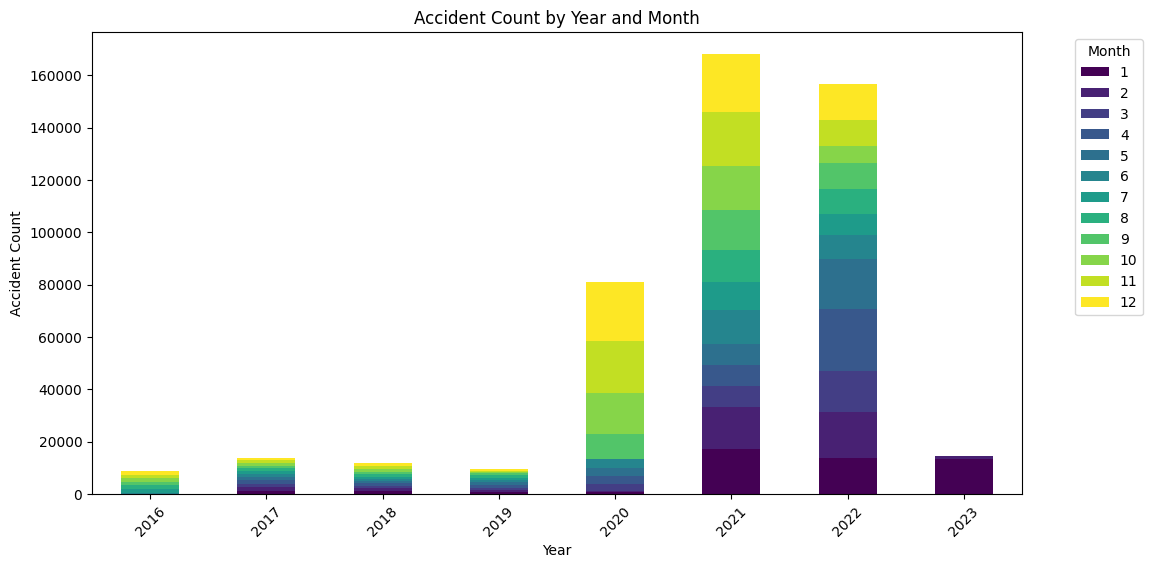

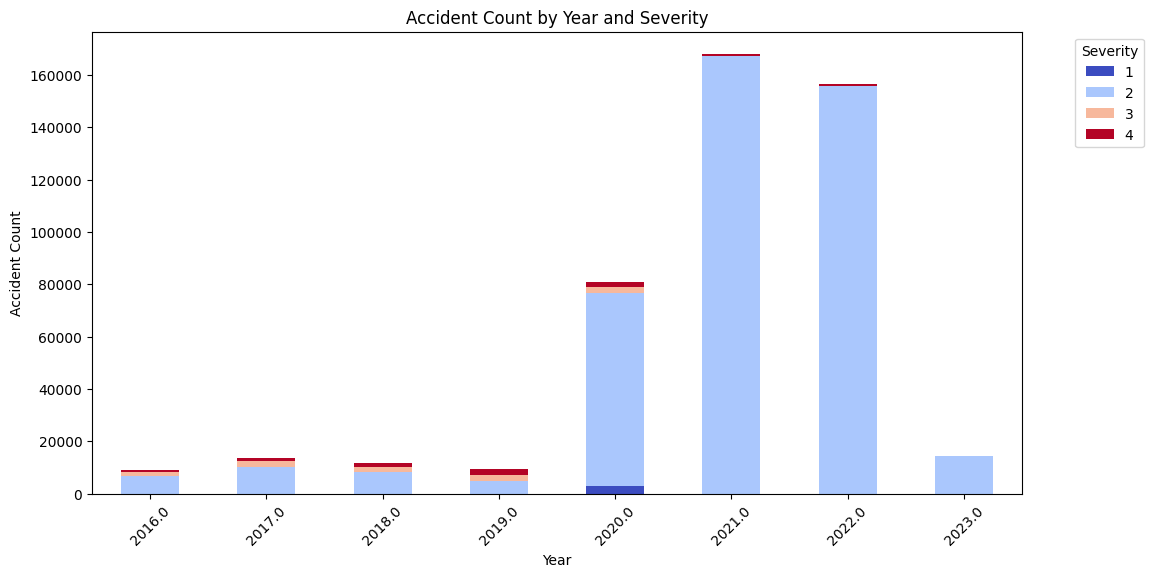

C:\Users\atul1\AppData\Local\Temp\ipykernel_22656\841707740.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=street_counts.values, y=street_counts.index, palette="magma")


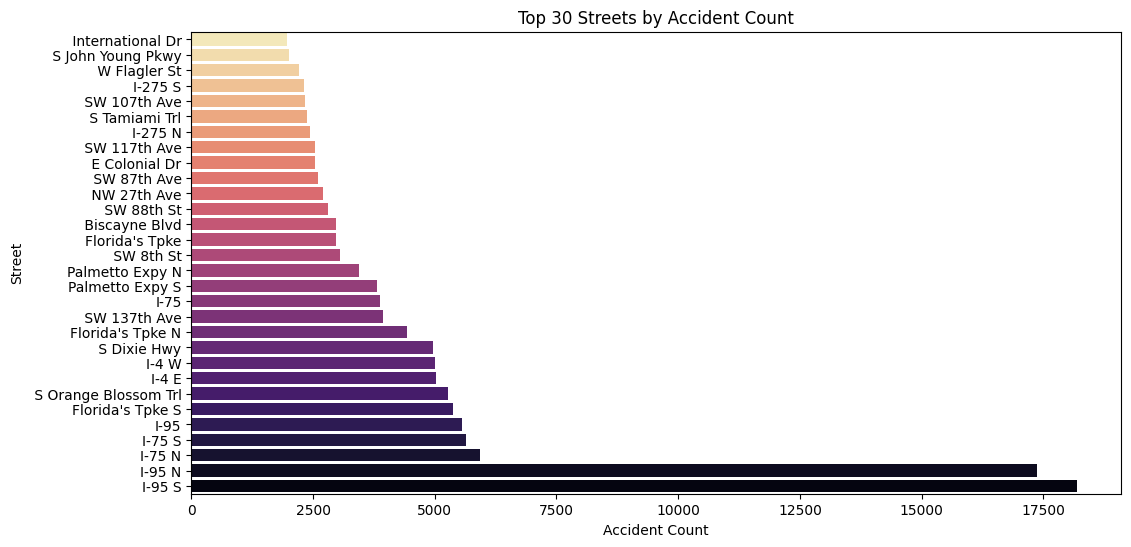

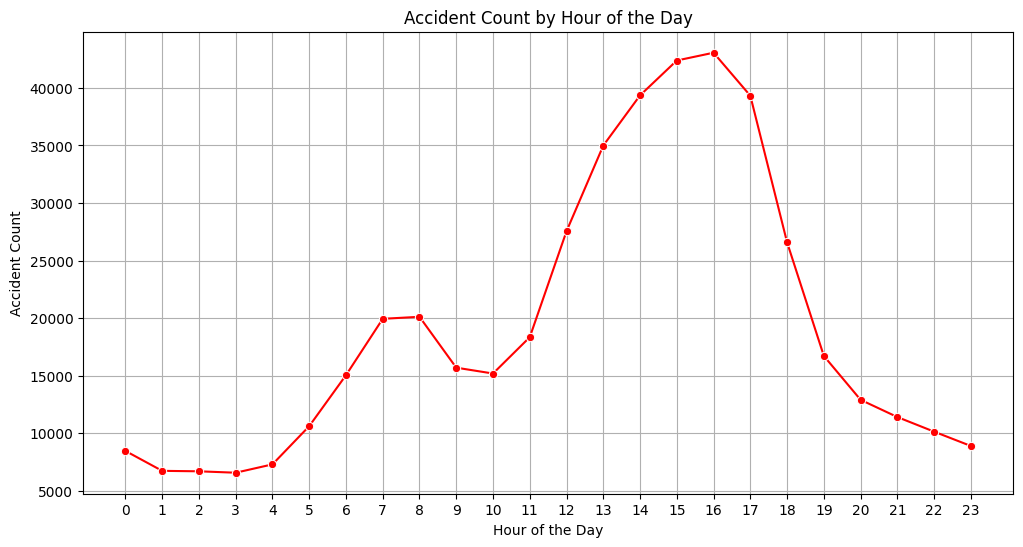

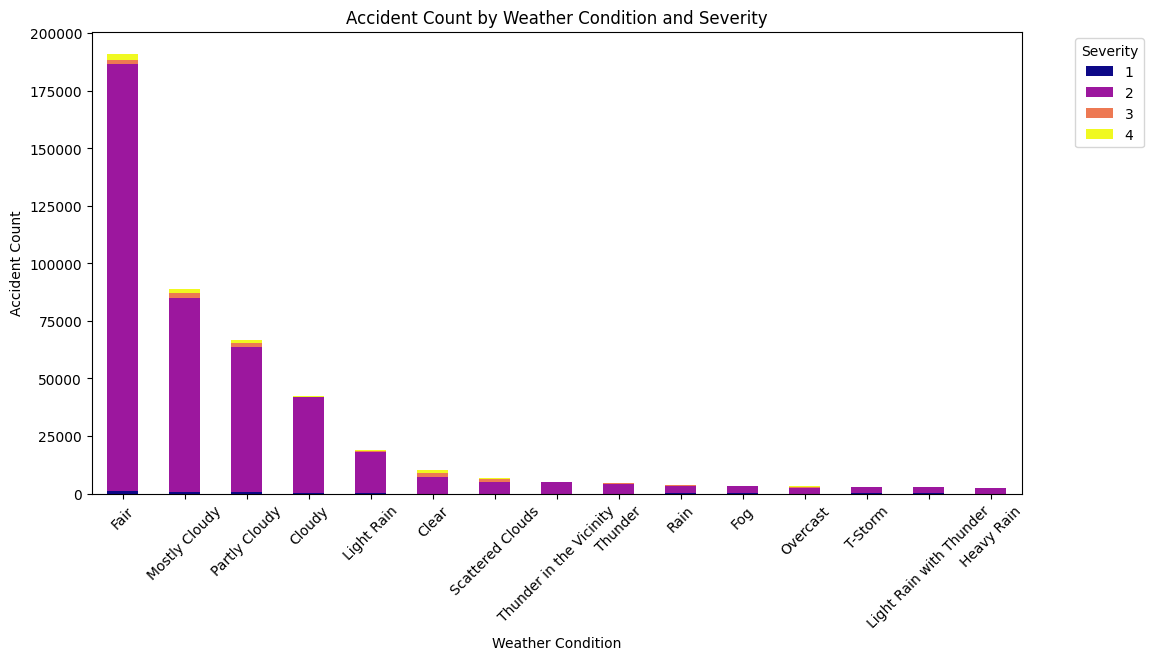

In [34]:
plot_accident_trend_by_month(fl_data_frame)
plot_accident_trend_by_severity(fl_data_frame)
plot_top_30_streets(fl_data_frame)
plot_accidents_by_hour(fl_data_frame)
plot_weather_vs_severity(fl_data_frame)

In [16]:

def analyze_visibility_temperature_effect_on_severity(data_frame, num_bins=5):
    """
    Analyzes the effect of visibility and temperature on accident severity using a Chi-Square test.

    Null Hypothesis (H0): Visibility and Temperature have no significant effect on accident severity.
    Alternative Hypothesis (H1): Visibility and Temperature significantly affect accident severity.

    Parameters:
        data_frame (pd.DataFrame): The dataset containing accident details.
        num_bins (int): Number of bins to create for visibility and temperature dynamically.

    Returns:
        dict: Chi-square test results including chi-square value, p-value, and degrees of freedom.
    """

    # Checking if required columns exist
    required_columns = ["Visibility(mi)", "Temperature(F)", "Severity"]
    missing_columns = [col for col in required_columns if col not in data_frame.columns]

    if missing_columns:
        print(f"Error: Missing columns in dataset: {missing_columns}")
        print(f"Available columns: {data_frame.columns.tolist()}")
        return None

    # Selecting relevant columns
    df = data_frame[required_columns].copy()

    # Handling missing values using .loc[]
    df.loc[:, "Visibility(mi)"] = df.loc[:, "Visibility(mi)"].fillna(df["Visibility(mi)"].median())
    df.loc[:, "Temperature(F)"] = df.loc[:, "Temperature(F)"].fillna(df["Temperature(F)"].median())

    # ✅ Dynamic Binning for Visibility using percentiles with .loc[]
    df["Visibility_Category"], visibility_bins = pd.qcut(df["Visibility(mi)"], q=num_bins, retbins=True, labels=False, duplicates="drop")
    visibility_labels = [f"Bin {i+1} ({visibility_bins[i]:.1f} - {visibility_bins[i+1]:.1f} mi)" for i in range(len(visibility_bins)-1)]
    df.loc[:, "Visibility_Category"] = df["Visibility_Category"].replace(range(num_bins), visibility_labels)

    # ✅ Dynamic Binning for Temperature using percentiles with .loc[]
    df["Temperature_Category"], temp_bins = pd.qcut(df["Temperature(F)"], q=num_bins, retbins=True, labels=False, duplicates="drop")
    temp_labels = [f"Bin {i+1} ({temp_bins[i]:.1f} - {temp_bins[i+1]:.1f}°F)" for i in range(len(temp_bins)-1)]
    df.loc[:, "Temperature_Category"] = df["Temperature_Category"].replace(range(num_bins), temp_labels)

    # Creating a contingency table for Visibility, Temperature, and Severity
    contingency_table = pd.crosstab(index=[df["Visibility_Category"], df["Temperature_Category"]], columns=df["Severity"])

    # Performing Chi-Square test
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

    # Printing results
    print("\nChi-Square Test Results:")
    print(f"Chi-Square Statistic: {chi2:.4f}")
    print(f"P-Value: {p:.6f}")
    print(f"Degrees of Freedom: {dof}")

    # Interpretation
    alpha = 0.05
    if p < alpha:
        print("\nConclusion: Reject the Null Hypothesis (H0). Visibility and Temperature significantly affect accident severity.")
    else:
        print("\nConclusion: Fail to Reject the Null Hypothesis (H0). No significant effect of visibility and temperature on severity.")

    # Returning results as a dictionary
    return {
        "Chi-Square Statistic": chi2,
        "P-Value": p,
        "Degrees of Freedom": dof,
        "Contingency Table": contingency_table
    }

# Running the function on the dataset
results = analyze_visibility_temperature_effect_on_severity(fl_data_frame, num_bins=2)
print("******** result  ****** \n")
print(results)
print("\nContingency Table:\n")
print(results["Contingency Table"])

# Save contingency table to CSV for further analysis
results["Contingency Table"].to_csv("visibility_temperature_severity_contingency.csv")
print("\nContingency Table saved as 'visibility_temperature_severity_contingency.csv'")

# Display contingency table if function executes successfully
#if results:
    #import ace_tools as tools
    #tools.display_dataframe_to_user(name="Dynamic Visibility & Temperature vs Severity Contingency Table", dataframe=results["Contingency Table"])



Chi-Square Test Results:
Chi-Square Statistic: 380.7506
P-Value: 0.000000
Degrees of Freedom: 9

Conclusion: Reject the Null Hypothesis (H0). Visibility and Temperature significantly affect accident severity.
******** result  ****** 

{'Chi-Square Statistic': np.float64(380.7505967845584), 'P-Value': np.float64(1.746091086812527e-76), 'Degrees of Freedom': 9, 'Contingency Table': Severity                                          1       2     3     4
Visibility_Category    Temperature_Category                            
Bin 1 (0.0 - 10.0 mi)  Bin 1 (19.0 - 77.0°F)   1072  221356  4747  5188
                       Bin 2 (77.0 - 107.0°F)  1812  219435  5954  4512
Bin 2 (10.0 - 23.0 mi) Bin 1 (19.0 - 77.0°F)      0       1     0     0
                       Bin 2 (77.0 - 107.0°F)     0       2     0     0}

Contingency Table:

Severity                                          1       2     3     4
Visibility_Category    Temperature_Category                            
Bin 1 (0.0 - 10.0 

C:\Users\atul1\AppData\Local\Temp\ipykernel_20724\3754131263.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Bin 1 (0.0 - 10.0 mi)' 'Bin 1 (0.0 - 10.0 mi)' 'Bin 1 (0.0 - 10.0 mi)'
 ... 'Bin 1 (0.0 - 10.0 mi)' 'Bin 1 (0.0 - 10.0 mi)'
 'Bin 1 (0.0 - 10.0 mi)']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, "Visibility_Category"] = df["Visibility_Category"].replace(range(num_bins), visibility_labels)
C:\Users\atul1\AppData\Local\Temp\ipykernel_20724\3754131263.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Bin 2 (77.0 - 107.0°F)' 'Bin 2 (77.0 - 107.0°F)'
 'Bin 2 (77.0 - 107.0°F)' ... 'Bin 2 (77.0 - 107.0°F)'
 'Bin 2 (77.0 - 107.0°F)' 'Bin 2 (77.0 - 107.0°F)']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, "Temperature_Category"]

In [50]:

def accident_severity_prediction_sampled(data_frame, sample_size=50000):
    # Selecting relevant features
    selected_features = ["Temperature(F)", "Humidity(%)", "Visibility(mi)", "Wind_Speed(mph)", 
                         "Start_Lat", "Start_Lng", "Traffic_Signal", "Junction", "Severity"]

    # Filtering dataset
    df = data_frame[selected_features].copy()

    # Handling missing values by filling with median values
    df.fillna(df.median(), inplace=True)

    # Converting boolean features to integers
    for col in ["Traffic_Signal", "Junction"]:
        df[col] = df[col].astype(int)

    # **Applying Stratified Sampling**
    df_sampled = df.groupby("Severity", group_keys=False).apply(lambda x: x.sample(n=min(len(x), sample_size // 4), random_state=42))
    
    print(f"Sampled dataset size: {df_sampled.shape[0]} rows")

    # Splitting dataset into features (X) and target variable (y)
    X = df_sampled.drop(columns=["Severity"])
    y = df_sampled["Severity"]
    y = df_sampled["Severity"] - 1 

    # Train-test split (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Standardizing numerical features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model Training - Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train)

    # Model Training - XGBoost
    xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    xgb_model.fit(X_train_scaled, y_train)

    # Predictions
    rf_predictions = rf_model.predict(X_test_scaled)
    xgb_predictions = xgb_model.predict(X_test_scaled)

    # Model Evaluation Metrics
    rf_accuracy = accuracy_score(y_test, rf_predictions)
    xgb_accuracy = accuracy_score(y_test, xgb_predictions)

    rf_report = classification_report(y_test, rf_predictions)
    xgb_report = classification_report(y_test, xgb_predictions)

    rf_confusion_matrix = confusion_matrix(y_test, rf_predictions)
    xgb_confusion_matrix = confusion_matrix(y_test, xgb_predictions)

    print("\nRandom Forest Model Performance:")
    print("Accuracy:", rf_accuracy)
    print("Classification Report:\n", rf_report)
    print("Confusion Matrix:\n", rf_confusion_matrix)

    print("\nXGBoost Model Performance:")
    print("Accuracy:", xgb_accuracy)
    print("Classification Report:\n", xgb_report)
    print("Confusion Matrix:\n", xgb_confusion_matrix)

    # Visualizing Feature Importance for Random Forest
    feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=feature_importance, y=feature_importance.index, palette="coolwarm")
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Features")
    plt.title("Feature Importance in Predicting Accident Severity (Random Forest)")
    plt.show()

    # Return results as a dictionary
    return {
        "Random Forest Accuracy": rf_accuracy,
        "XGBoost Accuracy": xgb_accuracy,
        "Random Forest Classification Report": rf_report,
        "XGBoost Classification Report": xgb_report,
        "Random Forest Confusion Matrix": rf_confusion_matrix,
        "XGBoost Confusion Matrix": xgb_confusion_matrix
    }



C:\Users\atul1\AppData\Local\Temp\ipykernel_22656\714110738.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(df.median(), inplace=True)
C:\Users\atul1\AppData\Local\Temp\ipykernel_22656\714110738.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby("Severity", group_keys=False).apply(lambda x: x.sample(n=min(len(x), sample_size // 4), random_state=42))


Sampled dataset size: 35785 rows

Random Forest Model Performance:
Accuracy: 0.6297331284057566
Classification Report:
               precision    recall  f1-score   support

         0.0       0.64      0.56      0.60       577
         1.0       0.66      0.70      0.68      2500
         2.0       0.63      0.67      0.65      2140
         3.0       0.57      0.51      0.54      1940

    accuracy                           0.63      7157
   macro avg       0.63      0.61      0.62      7157
weighted avg       0.63      0.63      0.63      7157

Confusion Matrix:
 [[ 323  115   83   56]
 [  74 1760  327  339]
 [  64  301 1426  349]
 [  42  480  420  998]]

XGBoost Model Performance:
Accuracy: 0.5885147408131899
Classification Report:
               precision    recall  f1-score   support

         0.0       0.59      0.46      0.52       577
         1.0       0.62      0.74      0.67      2500
         2.0       0.59      0.65      0.62      2140
         3.0       0.51      0.37  

C:\Users\atul1\AppData\Local\Temp\ipykernel_22656\714110738.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=feature_importance.index, palette="coolwarm")


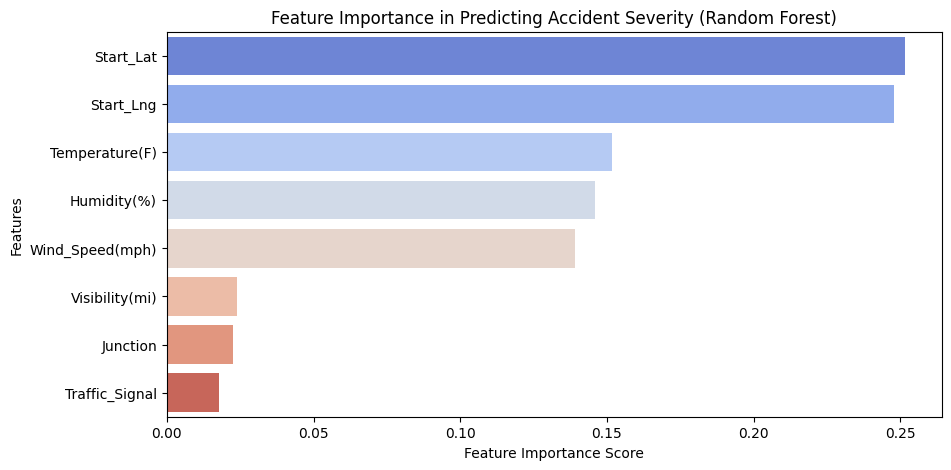

{'Random Forest Accuracy': 0.6297331284057566,
 'XGBoost Accuracy': 0.5885147408131899,
 'Random Forest Classification Report': '              precision    recall  f1-score   support\n\n         0.0       0.64      0.56      0.60       577\n         1.0       0.66      0.70      0.68      2500\n         2.0       0.63      0.67      0.65      2140\n         3.0       0.57      0.51      0.54      1940\n\n    accuracy                           0.63      7157\n   macro avg       0.63      0.61      0.62      7157\nweighted avg       0.63      0.63      0.63      7157\n',
 'XGBoost Classification Report': '              precision    recall  f1-score   support\n\n         0.0       0.59      0.46      0.52       577\n         1.0       0.62      0.74      0.67      2500\n         2.0       0.59      0.65      0.62      2140\n         3.0       0.51      0.37      0.43      1940\n\n    accuracy                           0.59      7157\n   macro avg       0.58      0.55      0.56      7157\n

In [51]:
accident_severity_prediction_sampled(fl_data_frame)